### Описание проекта

Нам предстоит работать с международным интернет-магазином компьютерных игр "Стримчик". У нас есть информация о данных о продажах игр, оценках пользователей и экспертов, жанрах и платформмах. Нам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед нами данные до 2016 года. Цель проекта - спланировать кампанию на 2017-й.

In [1]:
#Импортируем все библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st

### Предобработка данных

In [2]:
#Ознакомимся с данными
data = pd.read_csv('/datasets/games.csv')
pd.set_option('display.max_columns', None)
data.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [3]:
start_len_data= len(data) 
print(f'Всего строк:{start_len_data}')

Всего строк:16715


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


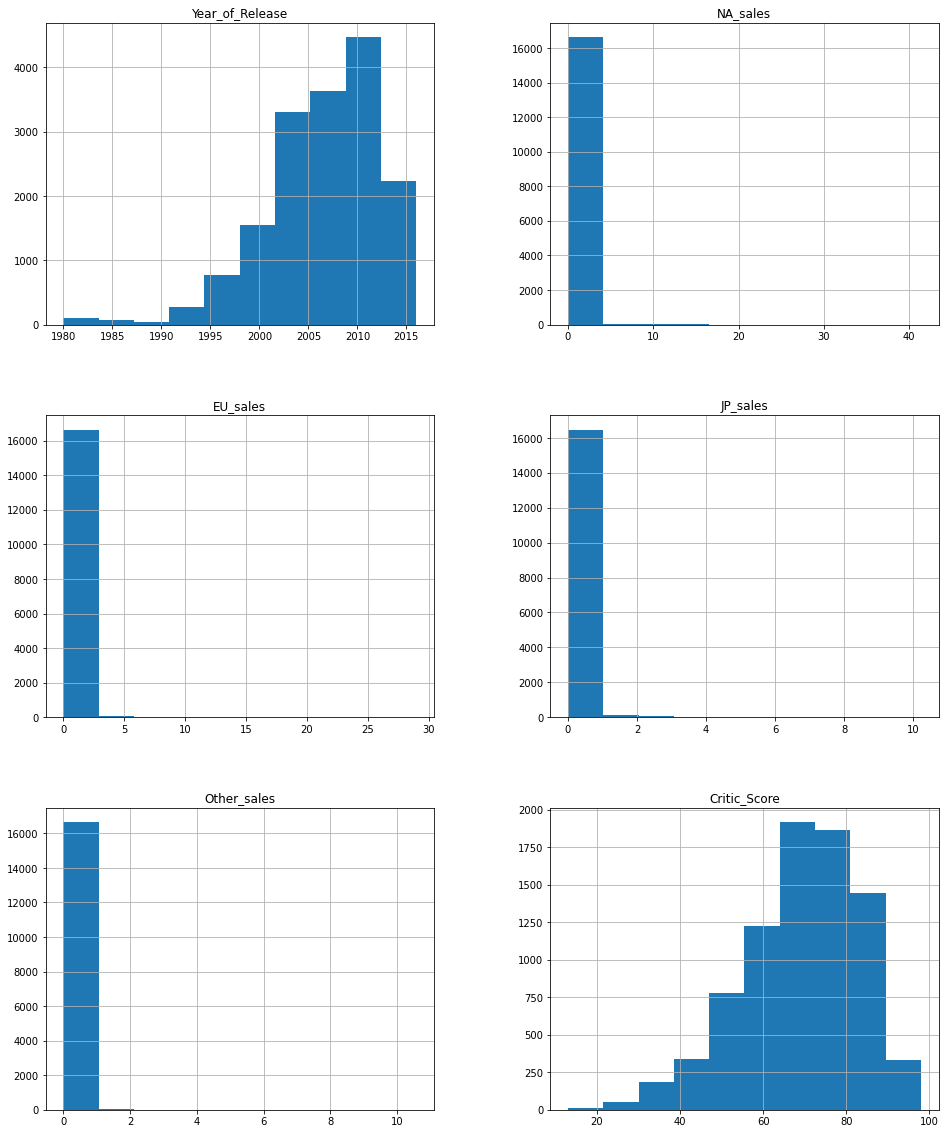

In [5]:
#попробуем оценить некоторые начальные данные
data.hist(figsize=(16, 20));

Из построенных гистограмм, можно сделать следующие выводы (за весь период с 1980 по 2016 года):

1. До 2013 года количество выпущенных в год игр увеличиволось, а потом резко пошло на спад.
2. Количество проданных копий в Северной Америке больше, чем в Европе почти в 2 раза. В Европе продаж больше, чем в Японии,  в Японии их примерно столько же, сколько в других странах вместе взятых.
3. Оценки критиков в большенстве выше среднего. Распределение оценок имеет отрицательную скошенность.


In [6]:
#проверка в каких столбцах есть пропуски:
for column in data:
    val_col = data[column]
    if val_col.isna().sum() > 0:
        print(column)    

Name
Year_of_Release
Genre
Critic_Score
User_Score
Rating


In [7]:
vec_for_count = ['Name', 'Year_of_Release', 'Genre', 'Critic_Score', 'User_Score', 'Rating']

for i in vec_for_count:
    isna_count = data[data[i].isna() == True]['Platform'].count()
    print(f'в {i} пропущенных значений ровно {isna_count}')   

в Name пропущенных значений ровно 2
в Year_of_Release пропущенных значений ровно 269
в Genre пропущенных значений ровно 2
в Critic_Score пропущенных значений ровно 8578
в User_Score пропущенных значений ровно 6701
в Rating пропущенных значений ровно 6766


В столбцах Platform, NA_sales, EU_sales, JP_sales нет пропусков, значит, в них нужно будет только проводить корректировки, возможно. В столбцах Name и Genre пропущенно  по 2 значения, и эти данные восстановить невозможно, хотя они являются важными, поэтому эти строки придется удалить, но это очень маленький процент от всех данных. В столбце Year_of_Release также есть пропуски, нужно посчитать какой процент от общих да. В столбцах с оценками (Critic_Score и User_Score) видно наличие множества пропусков данных, однако заменить их на среднее или медианное значение будет некорректно, так как это исказит реальную картину. Можно поставить на места пропусков "значения заглушки", например заменить пропуски на число 555, в этом случаем мы сможем работать со столбцами и нам будет легко отсеить эти значения (они будут аномальными, так как у нас дан конкретный диапозон от 0 до 10/100). Столбец Rating также не обязателен для всех исследований и нельзя восстановить данные в нем, поэтому считаю нужным оставить его пропуски без изменений, просто заменить их на 0 для удобства работы. 

In [8]:
#удаляем столбцы, где нельзя заполнить значения
data = data[data['Name'].isna() == False].reset_index(drop=True) 
data = data[data['Genre'].isna() == False].reset_index(drop=True)

In [9]:
#посчитаем процент пропусков в столбце Year_of_Release от общего числа значений
isna_Year_of_Release = data[data['Year_of_Release'].isna() == True]['Platform'].count()
print(f'процент пропусков в столбце Year_of_Release от общего числа значений {(isna_Year_of_Release/start_len_data)*100}%')

процент пропусков в столбце Year_of_Release от общего числа значений 1.609332934489979%


Процент действительно совсем небольшой, так что можем удалить строки с пропусками

In [10]:
data = data[data['Year_of_Release'].isna() == False].reset_index(drop=True)

Чтобы реализовать заполнение пропусков в столбце User_Score, необходимо рассмотреть значение 'tbd', которое часто встречается в этом столбце (означает "не приемлемо"). Заменим его на NaN, чтобы было удобно работать.

In [11]:
data['User_Score'] = data['User_Score'].replace('tbd', np.nan)

In [12]:
data['User_Score'] = data['User_Score'].fillna('555')

In [13]:
#заполним пропуски в столбце Critic_Score
data['Critic_Score'] = data['Critic_Score'].fillna(555)

In [14]:
#заполним пропуски в столбце Rating
data['Rating'] = data['Rating'].fillna('0')

In [15]:
#проверим, остались ли пропуски в датафрейме
sum_isna = 0
for column in data:
    val_col = data[column]
    sum_isna += val_col.isna().sum()
if sum_isna == 0:
    print('все пропуски заполнены')
else:
    print('остались пропуски')

все пропуски заполнены


Для удобства привидем названия столбцов к нижнему регистру:

In [16]:
data.columns = data.columns.str.lower() 
print(data.columns)

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')


In [17]:
#проверка явных дубликатов
print(data.duplicated().sum())

0


Попробуем понять причины появления пропусков, для этого вспомним в каких столбцах они были и в каком количестве:

- в Name пропущенных значений ровно 2
- в Year_of_Release пропущенных значений ровно 269
- в Genre пропущенных значений ровно 2
- в Critic_Score пропущенных значений ровно 8578
- в User_Score пропущенных значений ровно 6701
- в Rating пропущенных значений ровно 6766

В столбцах Name, Genre и Year_of_Release скорее всего технические пропуски или некоторые из них из-за человеческого фактора, потому что у каждый игы должны имется эти данные. В остальных же столбцах пропуски вполне логичны и объяснимы. Так, в Critic_Score и в User_Score не достает большого количества данных, так как далеко не все пользователи и далеко не на все игры пишут отзывы, то же самое можно сказать и о критиках, они обращают внимание на какие-то более значимые или популярные продукты. Также много пропусков в Rating. Что касается этого столбца, то рейтинг ESRB предназначен для маркировки игр для США и Канады. И логично, что для других регионов он не заполняется. В других странах есть свои рейтинги. То есть, в данном случае пропуск имеет признак, что игра выпущена не в Северо-Американском регионе.

Проверим предположение, что столбцы 'year_of_release', 'critic_score' имеют на самом деле целочисленный тип, и, если это так, совершим преобразование данных

In [18]:
#проверим предположение
vec_check = ['year_of_release', 'critic_score']
for val in vec_check:
    k = data[val].multiply(10).mod(10).sum()
    print('cумма десятичных частей в', val, k)

cумма десятичных частей в year_of_release 0.0
cумма десятичных частей в critic_score 0.0


In [19]:
#предположение выполнелось => преобразовываем
for val in vec_check:
    data[val] = data[val].astype('int')

Так же считаю нужным заменить типы данных в столбцах 'user_score', 'rating' на float, category соответственно

In [20]:
data['user_score'] = data['user_score'].astype('float')
data['rating'] = data['rating'].astype('category')

In [21]:
#Удостоверимся, что все типы данных успешно изменены
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16444 entries, 0 to 16443
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   name             16444 non-null  object  
 1   platform         16444 non-null  object  
 2   year_of_release  16444 non-null  int64   
 3   genre            16444 non-null  object  
 4   na_sales         16444 non-null  float64 
 5   eu_sales         16444 non-null  float64 
 6   jp_sales         16444 non-null  float64 
 7   other_sales      16444 non-null  float64 
 8   critic_score     16444 non-null  int64   
 9   user_score       16444 non-null  float64 
 10  rating           16444 non-null  category
dtypes: category(1), float64(5), int64(2), object(3)
memory usage: 1.3+ MB


Необходимо проверить, какой процент от изначальных данных был удален и не превосхдит ли он 10%:

In [22]:
print(f'удаленный процент составил {100 - (len(data)/start_len_data)*100} %')

удаленный процент составил 1.6212982351181608 %


In [23]:
# Комментарий ревьюера
# Посмотрим, что у нас осталось
temp = data.copy() 
list_c = ['name', 'platform', 'year_of_release', 'genre', 'critic_score', 'user_score', 'rating']
print(temp.info())
for col_l in list_c:
  print('-'* 25)
  print(col_l, temp[col_l].sort_values().unique())
  print(col_l,' : кол-во 0', temp[temp[col_l] == 0][col_l].count(),
        ', процент 0', round(temp[temp[col_l] == 0][col_l].count()/len(temp)*100, 2),'%')
  print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().sum()/len(temp)*100, 2),'%')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16444 entries, 0 to 16443
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   name             16444 non-null  object  
 1   platform         16444 non-null  object  
 2   year_of_release  16444 non-null  int64   
 3   genre            16444 non-null  object  
 4   na_sales         16444 non-null  float64 
 5   eu_sales         16444 non-null  float64 
 6   jp_sales         16444 non-null  float64 
 7   other_sales      16444 non-null  float64 
 8   critic_score     16444 non-null  int64   
 9   user_score       16444 non-null  float64 
 10  rating           16444 non-null  category
dtypes: category(1), float64(5), int64(2), object(3)
memory usage: 1.3+ MB
None
-------------------------
name [' Beyblade Burst' ' Fire Emblem Fates' " Frozen: Olaf's Quest" ...
 'uDraw Studio' 'uDraw Studio: Instant Artist'
 '¡Shin Chan Flipa en colores!']
name  : кол-во 0 0 , 

### Исследовательский анализ

Для дальнейших расчетов добавим отдельный столбец с суммарными продажами во всех регионах

In [24]:
data_total_sales = [['total_na_sales', data['na_sales'].sum()], ['total_eu_sales', data['eu_sales'].sum()], ['total_jp_sales', data['jp_sales'].sum()], ['total_other_sales', data['other_sales'].sum()]]

total_sales_sep = pd.DataFrame(data_total_sales, columns=['region', 'total_sales_in_region'])
print(total_sales_sep)

              region  total_sales_in_region
0     total_na_sales                4341.42
1     total_eu_sales                2399.68
2     total_jp_sales                1290.64
3  total_other_sales                 782.63


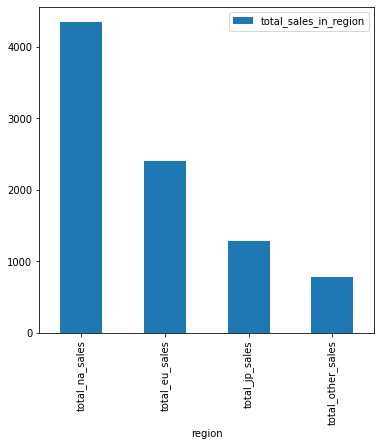

In [25]:
total_sales_sep.plot('region', 'total_sales_in_region', kind = 'bar', figsize = (6, 6))
plt.show()

Картина не изменилась после предобработки данных.Количество проданных копий в Северной Америке больше, чем в Европе почти в 2 раза. В Европе продаж больше, чем в Японии, в Японии их примерно столько же, сколько в других странах вместе взятых.

In [26]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

Посмотрим, сколько игр выпускалось в разные годы:

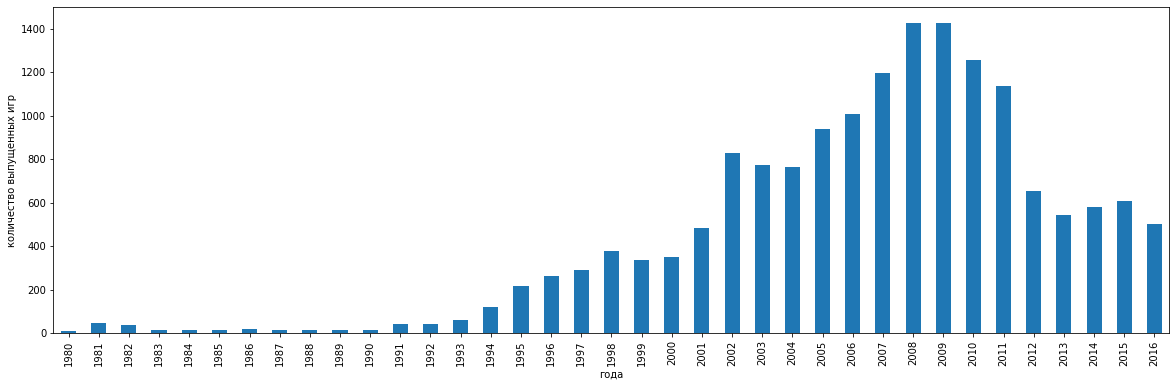

In [27]:
data.pivot_table(index = 'year_of_release', values = 'name', aggfunc = 'count').plot(kind = 'bar', figsize = (20,6), legend=False)
plt.xlabel('года')
plt.ylabel('количество выпущенных игр')
plt.show()

До 2009 года количество выпущенных игр в год увеличивалось, что вполне обусловлено техническим прогрессом, однако после этого периода произошел достаточно резкий спад. В последние 4-5 лет ситуация стабилизировалась и имеет средний показатель около 600 миллионов проданных копий.

<div style="border:solid green 3px; padding: 20px">

<b>Посмотрим как менялись продажи по платформам</b>

<AxesSubplot:title={'center':'Продажи по платформама'}, xlabel='platform'>

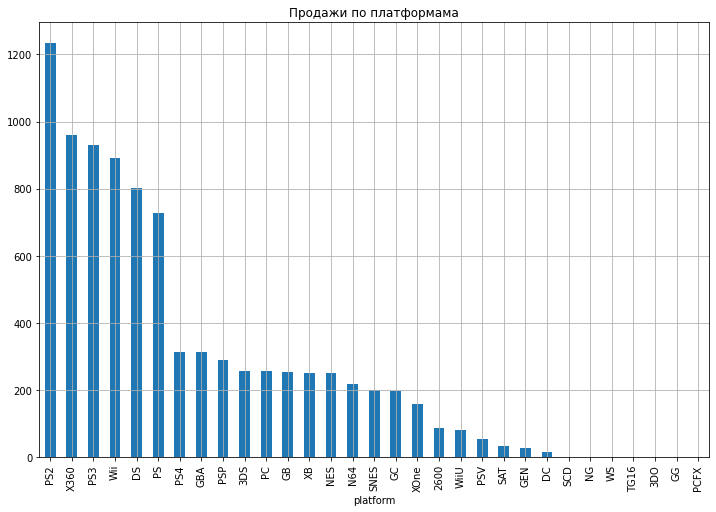

In [28]:
data.groupby('platform')['total_sales'].sum().sort_values(ascending = False).plot(kind = 'bar',grid = True, figsize = (12, 8), title = 'Продажи по платформама')

Выберем платформы с наибольшими суммарными продажами за весь период

In [29]:
top_plotforms = data.groupby('platform')['total_sales'].sum().sort_values(ascending = False).head(5).index.tolist()
print(f'Топ 5 платформ по продажам {top_plotforms}')

Топ 5 платформ по продажам ['PS2', 'X360', 'PS3', 'Wii', 'DS']


Построим график распределения продаж по годам для каждой платформы:

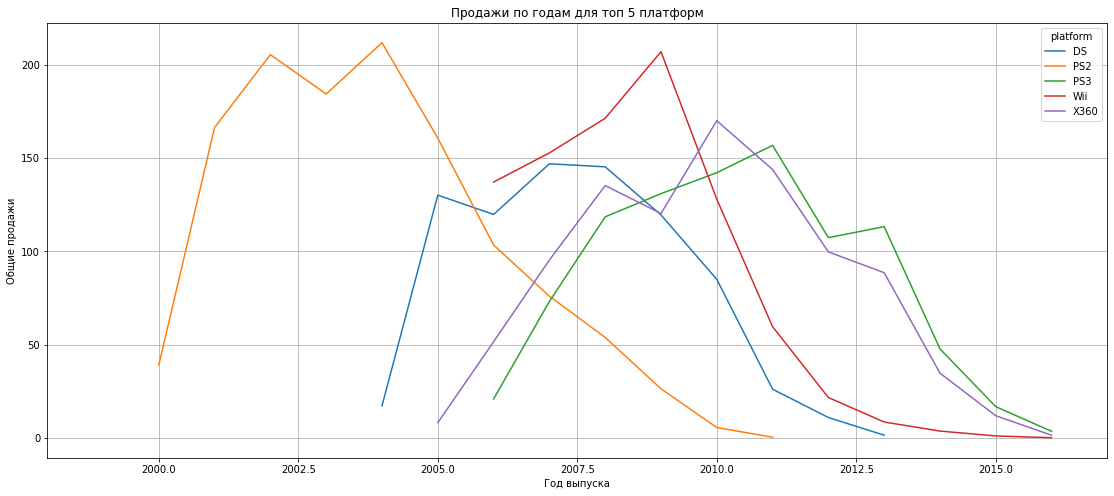

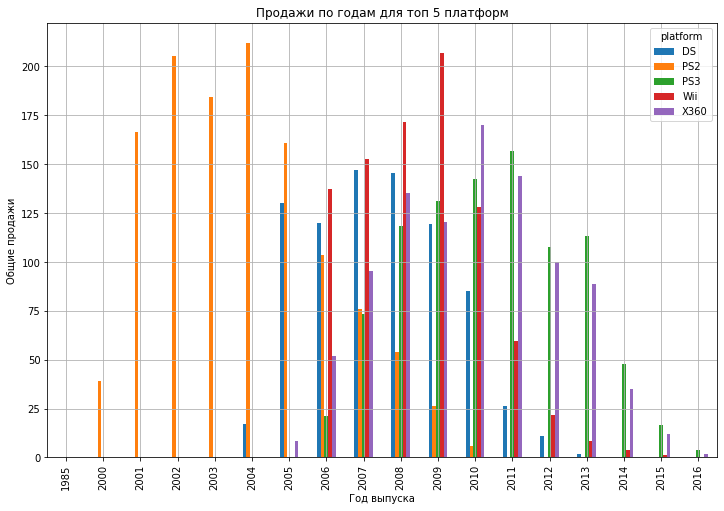

In [30]:
#Создадим сводную таблицу суммарных продаж по годам для вышеперечисленных платформ
top_plotforms_sales_by_year = data[data['platform'].isin(top_plotforms)].pivot_table(index = 'year_of_release', 
                                                                                    columns = 'platform',
                                                                                    values = 'total_sales',
                                                                                    aggfunc = 'sum')
top_plotforms_sales_by_year.plot(kind = 'line', grid = True, figsize = (19,8), xlim = (1998,2017))
plt.xlabel('Год выпуска')
plt.ylabel('Общие продажи')
plt.title('Продажи по годам для топ 5 платформ')
plt.show()

top_plotforms_sales_by_year.plot(kind = 'bar', grid = True, figsize = (12,8), xlim = (1998,2017))
plt.xlabel('Год выпуска')
plt.ylabel('Общие продажи')
plt.title('Продажи по годам для топ 5 платформ')
plt.show()

Судя по графикам, среднняя продолжительность жизни платформы около 10 лет, а активный рост продаж длится 4-5 лет.

<div style="border:solid green 3px; padding: 20px">

<b>Возьмем данные за актуальный период</b>

Не вижу смысла исследовать данные за весь предоставленный период, так как задача проекта - это выявить вектор, куда следует двигаться компании, то нам необходимо исследовать только актуальную информацию. Выше мы уже убедились, что платформа развивается в течении 4 - 5 лет, поэтому считаю нужным в качестве исследуемого периода оставить именно последние 4 года (с 2013 по 2016 г). К тому же сейчас время быстро меняющихся трендов и смен поколений, а значит, и их интересов. Так, психологами установленно, что именно 4 года - это срок, за который происходит эта смена (из этих соображений, например, олимпийский цикл длится 4 года).

In [31]:
data_new_1 = data[data['year_of_release']>=2013]
data_new = data_new_1[data_new_1['year_of_release']<=2016]

<div style="border:solid green 3px; padding: 20px">

<b>Посмотрим какие платформы лидируют по продажам, какие растут или падают. Выберите несколько потенциально прибыльных</b>

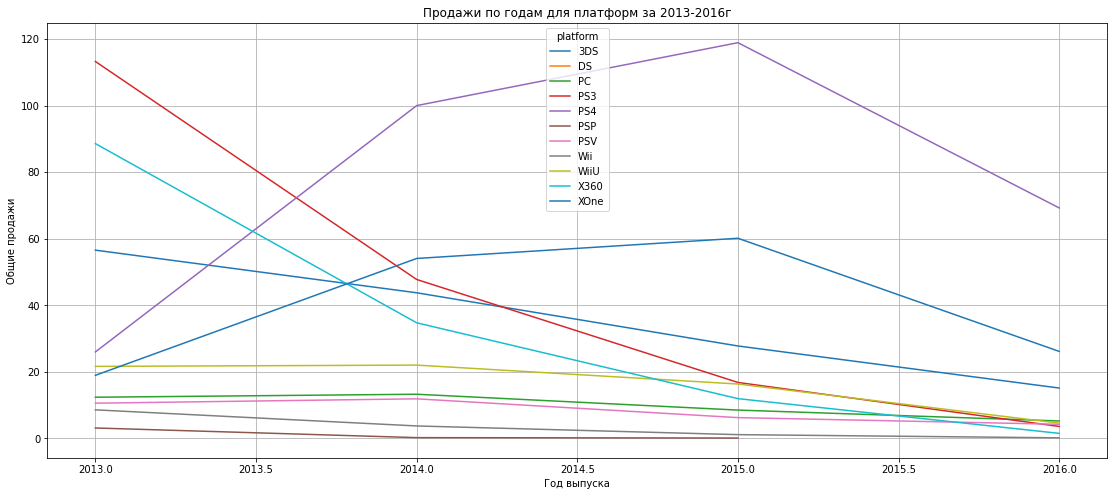

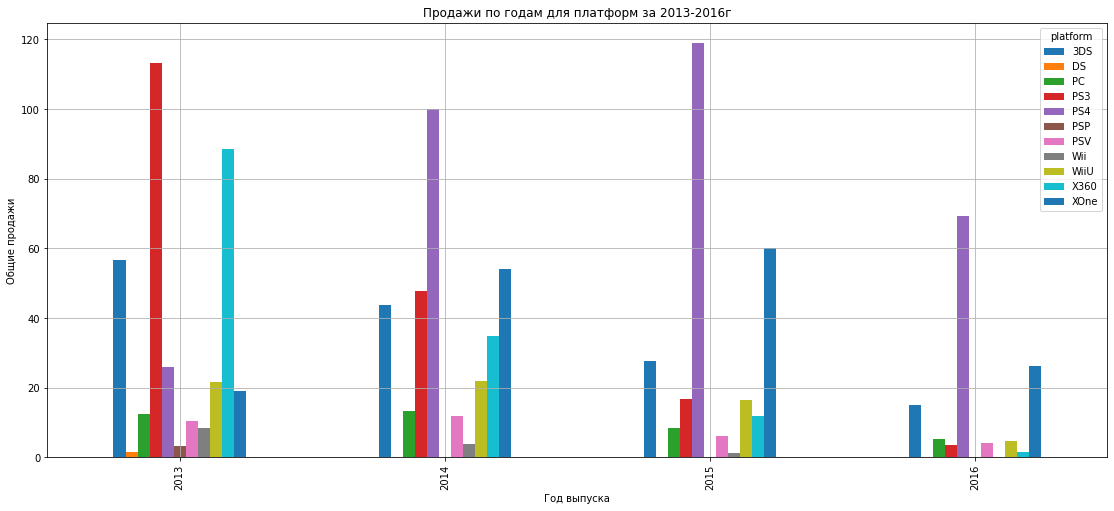

In [32]:
data_new.pivot_table(index = 'year_of_release', columns = 'platform', values = 'total_sales', aggfunc = 'sum').plot(kind = 'line', grid = True, figsize = (19,8))
plt.xlabel('Год выпуска')
plt.ylabel('Общие продажи')
plt.title('Продажи по годам для платформ за 2013-2016г')
plt.show()

data_new.pivot_table(index = 'year_of_release', columns = 'platform', values = 'total_sales', aggfunc = 'sum').plot(kind = 'bar', grid = True, figsize = (19,8))
plt.xlabel('Год выпуска')
plt.ylabel('Общие продажи')
plt.title('Продажи по годам для платформ за 2013-2016г')
plt.show()

Учитывая, что рост продаж длится приблизительно 5 лет, можно сделать вывод, что в ближайшие несколько лет активными перспективными платформами можно считать PS4 и Xone. Другие же платформы переживают стадию упадка продаж. Может показаться, что в 2016 году у всех платформ произошел упадок, но это не так, просто за этот год представленны не все данные.

In [33]:
perspective_platform = ['PS4', 'XOne']

<div style="border:solid green 3px; padding: 20px">

<b>Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам и посмотрим описание</b>

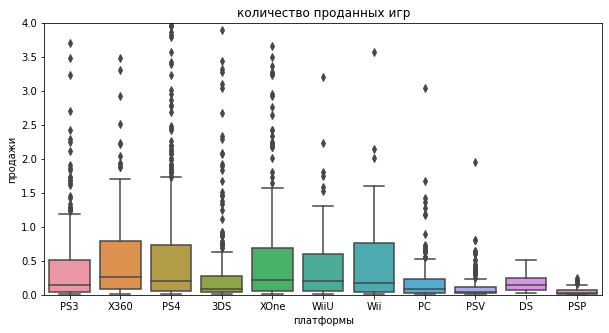

In [34]:
import seaborn as sns
fig, ax = plt.subplots(figsize = ( 10 , 5 ))

sns.boxplot( ax = ax , x = 'platform' , y = 'total_sales' , data = data_new )
  
ax.set(title = 'количество проданных игр', xlabel = 'платформы', ylabel = 'продажи', ylim=(0, 4))

plt.show()

In [35]:
print('Описание для общей стоимости')
for i in perspective_platform:
    print(f'для {i} :')
    display(data_new[data_new['platform'] == i]['total_sales'].describe()) 

Описание для общей стоимости
для PS4 :


count    392.000000
mean       0.801378
std        1.609456
min        0.010000
25%        0.060000
50%        0.200000
75%        0.730000
max       14.630000
Name: total_sales, dtype: float64

для XOne :


count    247.000000
mean       0.645020
std        1.036139
min        0.010000
25%        0.060000
50%        0.220000
75%        0.685000
max        7.390000
Name: total_sales, dtype: float64

Максимальное и медианное значение общей стоимости покупок игр больше у платформы PS4.
Рассмотрим отдельно по регионам дальше

In [36]:
vec_sal = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']
for i in perspective_platform:
    print(f'для {i} :')
    print(' ')
    for val in vec_sal:
        print(f'описание для {val}')
        print(' ')
        print(data_new[data_new['platform'] == i][val].describe())
        print(' ')

для PS4 :
 
описание для na_sales
 
count    392.000000
mean       0.277398
std        0.583723
min        0.000000
25%        0.007500
50%        0.060000
75%        0.260000
max        6.030000
Name: na_sales, dtype: float64
 
описание для eu_sales
 
count    392.000000
mean       0.359923
std        0.810843
min        0.000000
25%        0.000000
50%        0.080000
75%        0.300000
max        6.310000
Name: eu_sales, dtype: float64
 
описание для jp_sales
 
count    392.000000
mean       0.040714
std        0.069101
min        0.000000
25%        0.000000
50%        0.010000
75%        0.050000
max        0.490000
Name: jp_sales, dtype: float64
 
описание для other_sales
 
count    392.000000
mean       0.123342
std        0.254825
min        0.000000
25%        0.010000
50%        0.030000
75%        0.110000
max        2.380000
Name: other_sales, dtype: float64
 
для XOne :
 
описание для na_sales
 
count    247.000000
mean       0.377004
std        0.630618
min        0.0000

Рассматривая, вырученную сумму по регоинам, вывод остается такой же: самая прибыльная платформа это PS4

<div style="border:solid green 3px; padding: 20px">

<b>Посмотрим, как влияют на продажи внутри одной популярной платформы (PS4) отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.</b>

In [37]:
#данные с платформы PS4 за актуальный период
data_PS4 = data_new.query('platform == "PS4" ')

Так как вместо пропусков мы ставили "значения заглушки" (555), то нужно их отфильтровать, чтобы не иссказить результат

In [38]:
data_PS4_no_problem_critic_score = data_PS4.query('critic_score <= 100')
data_PS4_no_problem_user_score = data_PS4.query('user_score <= 10')

In [40]:
#посчитаем корреляцию между отзывами и продажами
data_for_corr = ['critic_score', 'user_score']

print(f'корреляция для critic_score =')
print(data_PS4_no_problem_critic_score['critic_score'].corr(data_PS4_no_problem_critic_score['total_sales']))

print(f'корреляция для user_score =')
print(data_PS4_no_problem_user_score['user_score'].corr(data_PS4_no_problem_user_score['total_sales']))

корреляция для critic_score =
0.40656790206178095
корреляция для user_score =
-0.031957110204556376


<AxesSubplot:xlabel='user_score', ylabel='total_sales'>

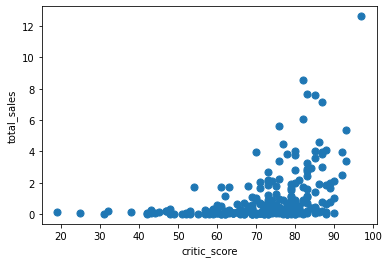

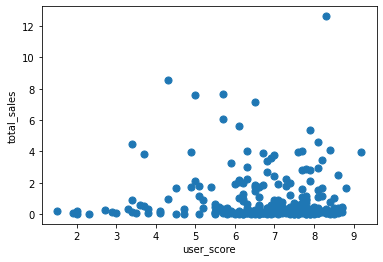

In [41]:
#построим диаграмму рассеяния
data_PS4_no_problem_critic_score.plot.scatter (x = 'critic_score', y = 'total_sales', s= 50)
data_PS4_no_problem_user_score.plot.scatter (x = 'user_score', y = 'total_sales', s= 50)

Из графиков и корреляции видно, что оценки критиков и продажи связаны, но не самым сильным образом. Это объяснимо, так как критики - это люди, разбирающиеся в играх, и они выше оценивают качественные продукты, которые в большей степени покупают люди.

Что касается оценок покупателей, то их корреляция с продажими почти стремится к 0.

<div style="border:solid green 3px; padding: 20px">

<b>Соотнесем выводы с продажами игр на других платформах</b>

In [42]:
#Все названия платформ за актуальный период
unique_name_platform_new = data_new['platform'].unique()
print(unique_name_platform_new)

['PS3' 'X360' 'PS4' '3DS' 'XOne' 'WiiU' 'Wii' 'PC' 'PSV' 'DS' 'PSP']


рассмотрим PS3
корреляция для user_score =
0.0023944027357566925
корреляция для critic_score =
0.3342853393371919


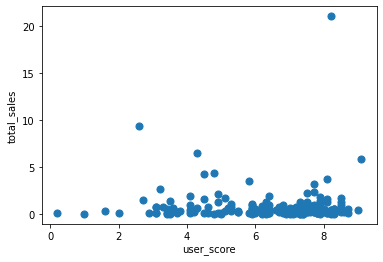

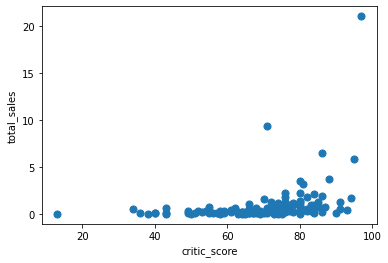

рассмотрим X360
корреляция для user_score =
-0.011742185147181342
корреляция для critic_score =
0.3503445460228664


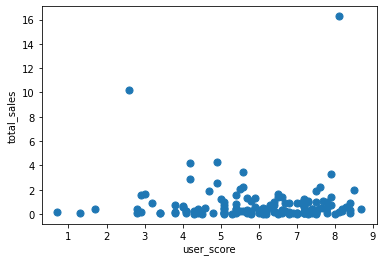

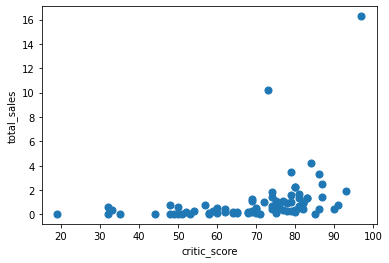

рассмотрим PS4
корреляция для user_score =
-0.031957110204556376
корреляция для critic_score =
0.40656790206178095


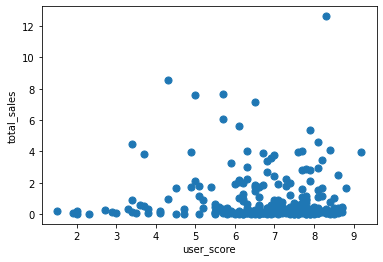

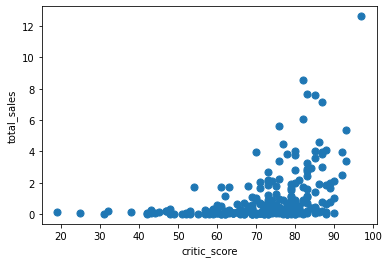

рассмотрим 3DS
корреляция для user_score =
0.24150411773563016
корреляция для critic_score =
0.3570566142288103


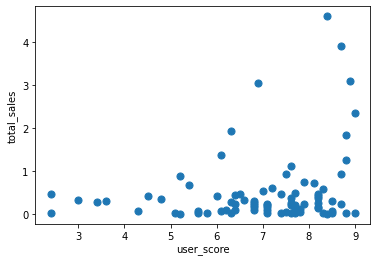

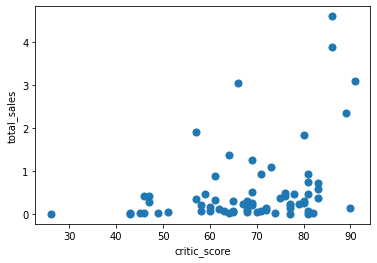

рассмотрим XOne
корреляция для user_score =
-0.06892505328279414
корреляция для critic_score =
0.4169983280084017


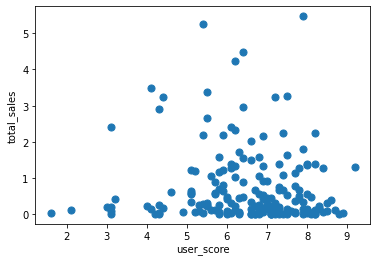

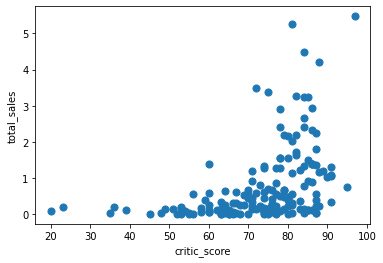

рассмотрим WiiU
корреляция для user_score =
0.4193304819266187
корреляция для critic_score =
0.3764149065423912


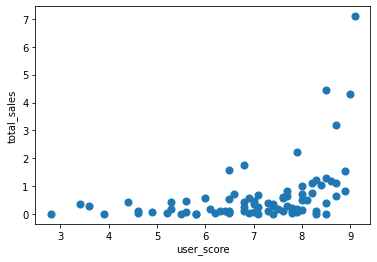

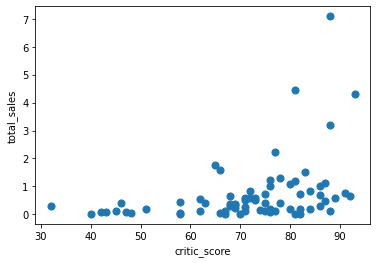

рассмотрим Wii
корреляция для user_score =
0.6829417215362368
корреляция для critic_score =
nan


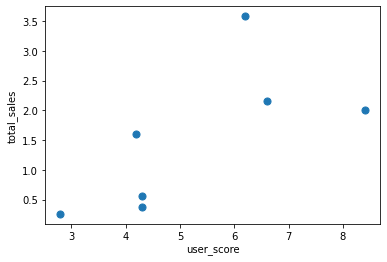

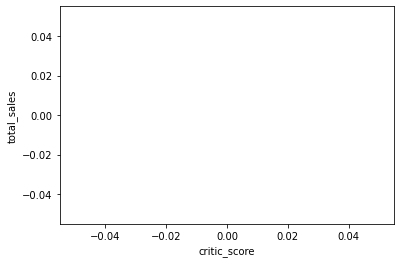

рассмотрим PC
корреляция для user_score =
-0.0938418695247674
корреляция для critic_score =
0.19603028294369382


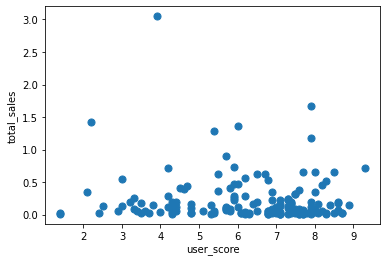

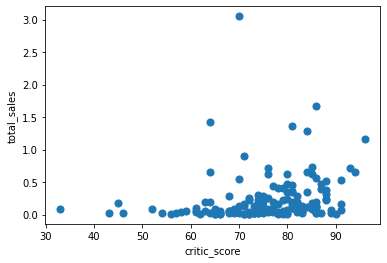

рассмотрим PSV
корреляция для user_score =
0.0009424723319108626
корреляция для critic_score =
0.2547423503068656


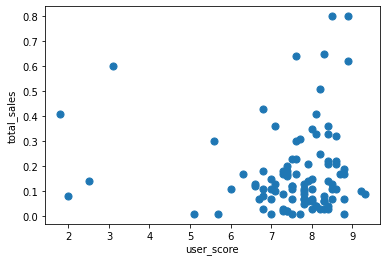

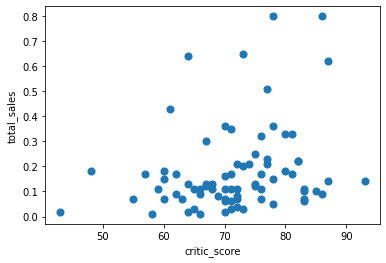

рассмотрим DS
корреляция для user_score =
nan
корреляция для critic_score =
nan


/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


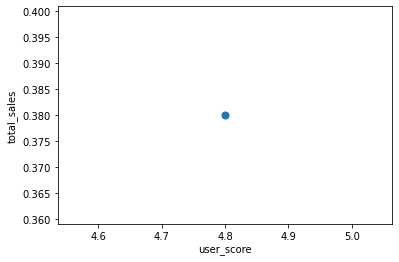

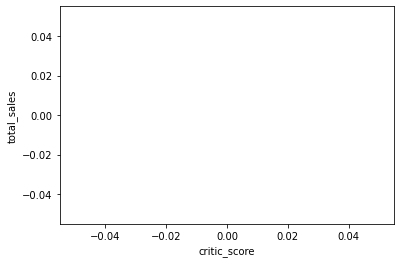

рассмотрим PSP
корреляция для user_score =
-0.9999999999999999
корреляция для critic_score =
nan


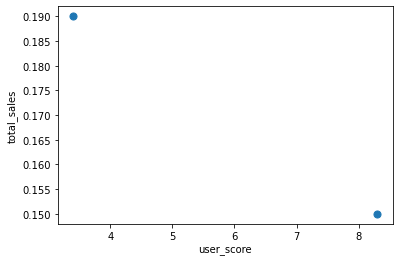

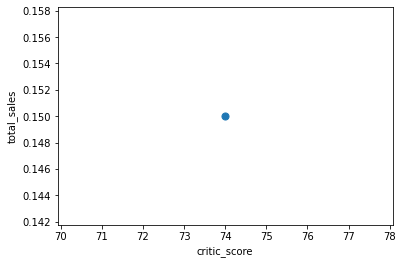

In [43]:
data_new_no_problem_critic_score = data_new.query('critic_score <= 100')
data_new_no_problem_user_score = data_new.query('user_score <= 10')


for val in unique_name_platform_new:
    print(f'рассмотрим {val}')
    data_new_no_problem_val_user_score = data_new_no_problem_user_score[data_new_no_problem_user_score['platform'] == val]
    data_new_no_problem_val_critic_score = data_new_no_problem_critic_score[data_new_no_problem_critic_score['platform'] == val]
    #посчитаем корреляцию между отзывами и продажами
    print(f'корреляция для user_score =')
    print(data_new_no_problem_val_user_score['user_score'].corr(data_new_no_problem_val_user_score['total_sales']))
    print(f'корреляция для critic_score =')
    print(data_new_no_problem_val_critic_score['critic_score'].corr(data_new_no_problem_val_critic_score['total_sales']))
    #построим диаграмму рассеяния
    data_new_no_problem_val_user_score.plot.scatter (x = 'user_score', y = 'total_sales', s= 50)
    plt.show()
    data_new_no_problem_val_critic_score.plot.scatter (x = 'critic_score', y = 'total_sales', s= 50)
    plt.show()

Если смотреть на значения корреляций и графики, то можно понять, что будет справедливым распространить вывод для самой популярной платформы на все остальные. Корреляция для оценки критиков варьируется в примерно в одном диапозоне для всех платформа (~ 0,3 - 0,45), а корреляция для оенки покпателей колеблется в районе 0. 

Есть значения корреляции равные nan, это происходит из-за отсутствие этих данных в изначальном датафрейме, так как исследуем мы часть данных без 'заглушек', которые заполняли пропуски

<div style="border:solid green 3px; padding: 20px">

<b>Посмотрим на общее распределение игр по жанрам</b>

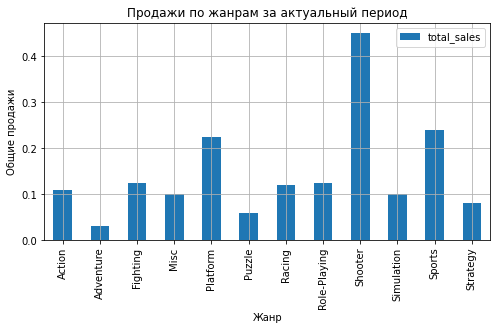

In [44]:
data_genre = data_new.pivot_table(index = 'genre', values = 'total_sales', aggfunc = 'median')
data_genre.plot(kind = 'bar', grid = True, figsize = (8,4))
plt.xlabel('Жанр')
plt.ylabel('Общие продажи')
plt.title('Продажи по жанрам за актуальный период')
plt.show()

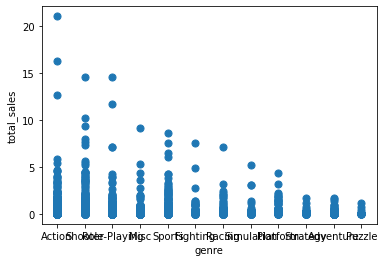

In [45]:
data_y = data_new.groupby('genre').median()[['total_sales']]
data_new.plot.scatter (x = 'genre', y = 'total_sales', s= 50)
plt.show()

Самым прибыльным жанром (судя по медианным значениям) игр оказался shooter, а самые низкие продажи - у advanture. Если выделять топ самых прибыльных жанров, то в него войдут: shooter, sports, platform, action, role-playing и fighting.

### Составим портрет пользователя каждого региона

Определим для пользователя каждого региона (NA, EU, JP):

- Самые популярные платформы (топ-5). Опишите различия в долях продаж.
- Самые популярные жанры (топ-5). Поясните разницу.
- Влияет ли рейтинг ESRB на продажи в отдельном регионе?

<div style="border:solid green 3px; padding: 20px">

<b>Самые популярные платформы (топ-5)</b>

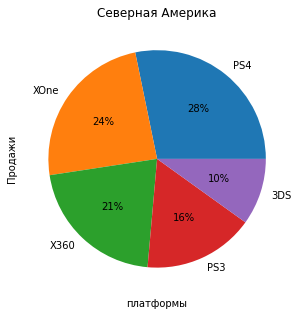

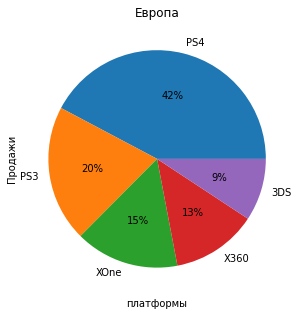

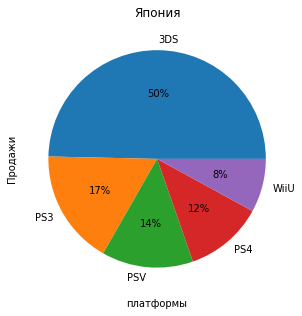

In [46]:
vec_reg = ['na_sales', 'eu_sales', 'jp_sales']

for i in vec_reg:
    data_na = data_new.pivot_table(index = 'platform', values = i, aggfunc = 'sum').sort_values(by = i, ascending=False).head(5)
    data_na.plot(kind = 'pie', figsize = (5,5), subplots=True, autopct='%1.0f%%')
    plt.xlabel('платформы')
    plt.ylabel('Продажи')
    if i == 'na_sales':
        plt.title('Северная Америка')
    elif i == 'eu_sales':
        plt.title('Европа')
    else:
        plt.title('Япония')
    plt.legend().remove()
    plt.show()

Северная Америка:
- самыая популярная платформа: PS4 (25%)
- наименее популярная платформа: 3DS (10%)
- Однако платформы X360 (24%) и XOne (23%) не особо отличаются от PS4

Европа:
- самыая популярная платформа: PS4 (38%)
- наименее популярная платформа: 3DS (10%)
- Однако остальные платформы заметно отличаются от PS4, ближайшее значение это 23% у PS3

Япония:
- самыая популярная платформа: 3DS (51% то есть больше половины)
- наименее популярная платформа: WiiU (9%)
- Однако остальные платформы заметно отличаются от 3DS, ближайшее значение это 19% у PS3

Общий вывод:

Специфика региона явно влияет на лидирующие по продажам платформы. Так, 3DS закрывает пятерку популярные платформ в Северной Америке и Европе, а в Японии, наоборот, открывает. Также в Северной Америке более равномерное распределение среди лидирующих платформ, а в той же Японии одна платформа охватывает больше половины продаж. Это объяснимо, так как азиатские страны в целом отличаются менталитетом и предпочтениями от других стран, поэтому и рынок игр там также отличается.

<div style="border:solid green 3px; padding: 20px">

<b>Самые популярные жанры (топ-5)</b>

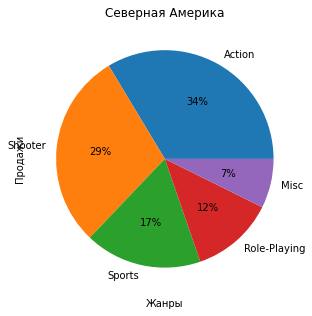

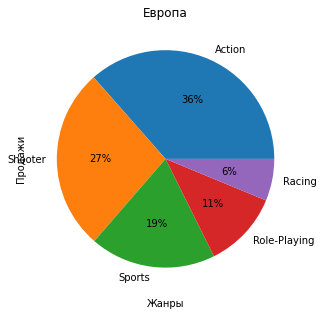

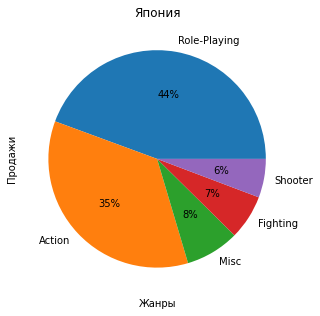

In [47]:
for i in vec_reg:
    data_na = data_new.pivot_table(index = 'genre', values = i, aggfunc = 'sum').sort_values(by = i, ascending=False).head(5)
    data_na.plot(kind = 'pie', figsize = (5,5), subplots=True, autopct='%1.0f%%')
    plt.xlabel('Жанры')
    plt.ylabel('Продажи')
    if i == 'na_sales':
        plt.title('Северная Америка')
    elif i == 'eu_sales':
        plt.title('Европа')
    else:
        plt.title('Япония')
    plt.legend().remove()
    plt.show()

Северная Америка:

- самый популярный жанр: Action (35%)
- наименее популярный жанр: Misc (8%)
- ближайший по популярности жанр к Action это Shooter (28%)

Европа:
- самый популярный жанр: Action (38%)
- наименее популярный жанр: Misc (7%)
- ближайший по популярности жанр к Action это также Shooter (26%)

Япония:
- самый популярный жанр: Role-Playing (45%)
- наименее популярный жанр: Shooter (6%), который в других странах был на 2 месте в топе
- ближайший по популярности жанр к Role-Playing это Action (34%)

Общий вывод:

Жанр Action популярен во всех странах, а misc = наоборот, не востребован. Однако стоит отметить, что японский рынок спецефичиский. В Северной Америке и Европе более равномерное распределение между жанрами, а в Японии есть четкие лидеры.

<div style="border:solid green 3px; padding: 20px">

<b>Влияние рейтинга ESRB на продажи в отдельном регионе</b>

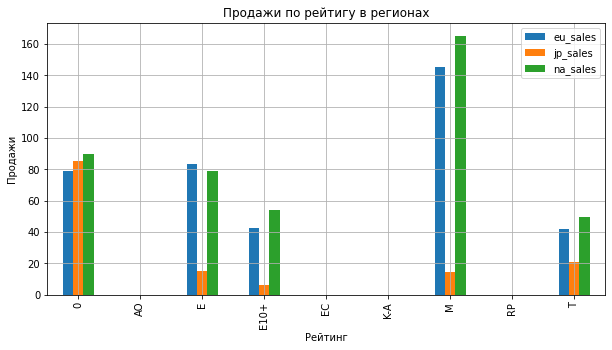

In [48]:
data_esrb = data_new.pivot_table(index = 'rating', values = ['na_sales', 'eu_sales', 'jp_sales'], aggfunc = 'sum')
data_esrb.plot(kind = 'bar', grid = True, figsize = (10,5))
plt.xlabel('Рейтинг')
plt.ylabel('Продажи')
plt.title('Продажи по рейтигу в регионах')
plt.show()

- 0 - это значение-загллушка, то есть пропуски в данных. Таких значений достаточно много во всех регионах.
- Количество игр, у которых K-A рейтинг, около 0, так как это устаревшие обозначение, которое использовалось до 1988г.
- ЕС рейтинг также у очень малого количества игр, так как сегмент игр для детей до 10 лет не так обширен.
- ОА рейтинг очень не распространен, та как это направление в играх опять же не популярное.
- RP значений мало, так как малый процент игр ожидали получение рейтинга на момент сбора данных.
- Значительно больше продаж для категории T, то есть для подростков.
- E10+ также весьма популярная категория для Северной Америки и Европы, а для Японии уже нет. Видимо, детей в возрасте от 10 до 13 лет в Японии больше занимают другие дела, помимо игр, возможно, там более строгое воспитание.
- Категория Е одна из самых распространенных. Это вполне объяснимо, так как категория "для всех" включает в себя все возраста.
- М категория самая популярная в Северной Америке и Европе, в Японии тоже, но не в иаком размере. Это явление логично, так как возростной промежуток 17-25 лет - это самая многочисленная группа, активно покупающая товары данной категории, а М - это игры 17+.

### Проверим гипотезы

Выбирем alpha=0,05. Это говорит о том что суммарная вероятность того, что измеренное эмпирически значение окажется далеко от среднего равна 5%.

Использовать будем метод  st.ttest_ind(), так как перед нами стоит задача проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них (независимым) выборкам.

<div style="border:solid green 3px; padding: 20px">

<b>1.
    
H₀:Средние пользовательские рейтинги платформ XOne и PC равны. - нулевая гипотеза
    
H₁:Средние пользовательские рейтинги платформ XOne и PC не равны. - альтернативная гипотеза</b>

In [49]:
#данные без значений-заглушек
data_new_user=data_new[data_new['user_score']<=10] 

user_XOne = data_new_user.query('platform =="XOne"')['user_score']
user_PC = data_new_user[data_new_user['platform']=='PC']['user_score']


alpha = 0.05 # уровень статистической значимости
#если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_ind(user_XOne, user_PC, equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.14759594013430463
Не получилось отвергнуть нулевую гипотезу


То есть велика вероятность, что средние пользовательские рейтинги платформ XOne и PC равны и нулевая гипотеза не может быть отвергнута.

<div style="border:solid green 3px; padding: 20px">

<b>2.
    
H₀:Средние пользовательские рейтинги жанров Action и Sports равны.
    
H₁:Средние пользовательские рейтинги жанров Action и Sports не равны.</b>

In [50]:
user_Action = data_new_user.query('genre =="Action"')['user_score']
user_Sports = data_new_user[data_new_user['genre']=='Sports']['user_score']


alpha = 0.05 # уровень статистической значимости
#если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_ind(user_Action, user_Sports, equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.4460039700704315e-20
Отвергаем нулевую гипотезу


То есть гипотеза о том, что средние пользовательские рейтинги жанров Action и Sports равны, не жизнеспособна.

<div style="border:solid green 3px; padding: 20px">

<b>
    Нулевую гипотезу я сформулировала таким образом, что бы она содержала равенство велечин, а альтернативную - чтобы она покрывала все остальные случаи (то есть не равенство), так как они вместе должны дать все возможные варианты.
    

К выборкам мы применили t-критерий при тестировании гипотез, потому что он используется для определения статистической значимости различий средних величин. t-критерий может применяться как в случаях сравнения независимых выборок, так и при сравнении связанных совокупностей (в нашем случае независимых).

### Общий вывод

- Цель анализа данных интернет-магазина «Стримчик», который продаёт по всему миру компьютерные игры, заключается в выявлении определяющих успешность игры закономерностях. Мы хотим понять на какой  потенциально популярный продукт следует сделать ставку  и спланировать рекламные кампании.


- Рассматривая только актуальный период и узнав средний срок жизни платформ, стало понятно, что самые перспективные из них - это PS4 и Xone, именно на них вероятнее всего в ближайшее время будут наибольшие продажи. Если рассматривать более детально восстребованность платформ по регионам, то в Северной Америке и Европе данные платформы занимают одни из лидирующих мест, а PS4 и вовсе возглавляет этот топ, в то время как специфический азиатский рынок, а конкретно Япония, имеют абсолютно другой состав топа платформ по продажам. В Японии наибольший интерес вызывает 3DS, продажи на которой составляют более 50% от топ 5 платформ. То есть платформы PS4 и Xone, действительно, можно рассматривать как приоритетные, но на японском рынке нужны будут корректировки.


- Самым популярным жанром в Северной Америке и Европе является Action, в Японии он тоже занимает высокое место в топе (2ое), однако в первых двух случаях на 2ом месте находится жанр Shooter, а в Японии он только замыкает топ 5. Лидер жанров на японском рынке - это Role-Playing. На основании этого, мы приходим к тому, что стоит сделать упор на жанр Action. Также удялять внимание Shooter, а опять же в Японии придерживаться иной стратегии и продвигать игры жанра Role-Playing.


- Также для рекламной компании лучше провести работу с критиками, так как их оценки игр влияют на продажи, в то время как ориентироваться на пользовательские оценки особо не нужно.



- Конечно, не стоит забывать про влияние рейтинга ESRB на продажи. Самым оптимальным вариантом сделять упор на игры категории М, так как они востребованы везде.


- Одно из самых важных открытий исследования заключается в том, что игровые предпочтения в Европе и Северной Америке схожи и для них можно, в целом, строить единую рекламную компанию и задавать один вектор направления, в то время как Япония (как частность азиатских стран скорее всего) значительно отличается и для нее нужен иной подхой. Этот факт вполне объясним, так как в азиатских странах другой менталитет, воспитание детей и, следовательно, предпочтения в разных областях, в том числе и на игровом рынке.